# Library imports, setup

In [1]:
#if you change a file, you dont have to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from data import load_metadata, visualize_data, make_dataset
from model import build_multitask_model
from score_metrics import get_scores
from loss import SoftF1Loss #custom loss function, currently not used

2025-11-30 15:23:03.997344: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 15:23:04.049382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 15:23:05.462540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")

2.20.0
Found GPU /physical_device:GPU:0, and set memory growth to True.


# Loading data

In [4]:
image_metadata, species_metadata = load_metadata()
NUM_SPECIES = len(species_metadata)

Number of classes: 296


/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["encoded_id"] = encoder.fit_transform(image_metadata["class_id"])
/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["image_path"] = image_metadata["image_path"].apply(


# Visualizing data

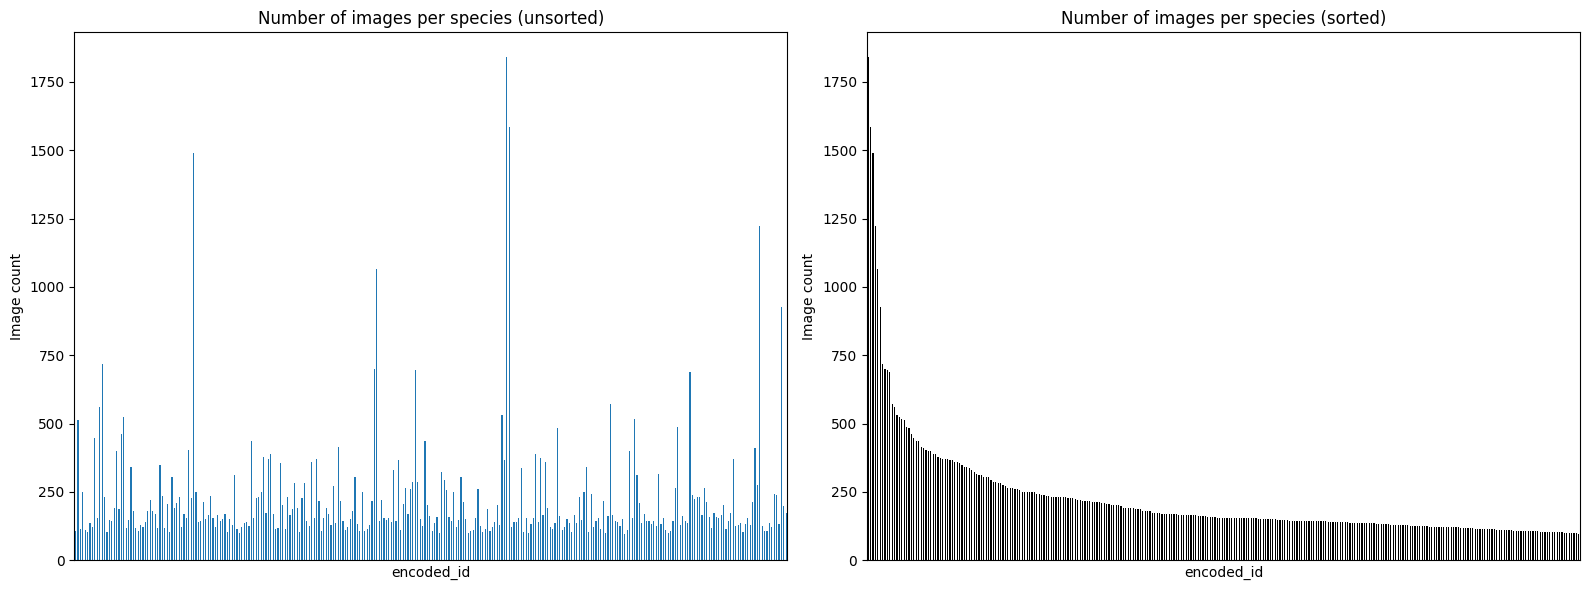

Maximum number per species class is 1839
Minimum number per species class is 96


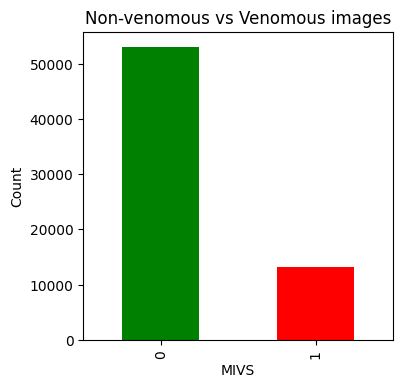

MIVS
0    53164
1    13290
Name: count, dtype: int64


In [5]:
#in data.py
visualize_data(image_metadata)

Loading python images from folder

# Building model

In [6]:
import tensorflow as tf
import keras

In [7]:
from sklearn.utils.class_weight import compute_class_weight
IMAGE_RESOLUTION=224
from data import make_batches, split_dataset

train_info, val_info, test_info = split_dataset(image_metadata)


species_classes = np.unique(train_info["encoded_id"])
species_cw = compute_class_weight(
    class_weight="balanced",
    classes=species_classes,
    y=train_info["encoded_id"],
)
species_cw_dict = {int(c): w for c, w in zip(species_classes, species_cw)}

species_weight_vec = tf.constant(
    [species_cw_dict[i] for i in range(len(species_cw_dict))],
    dtype=tf.float32,
)


#split dataset and make batches
train_dataset = make_batches(
    train_info,
    IMAGE_RESOLUTION,
    species_weight_vec=species_weight_vec,
)

val_dataset = make_batches(
    val_info,
    IMAGE_RESOLUTION,
    species_weight_vec=None,
)

test_dataset = make_batches(
    test_info,
    IMAGE_RESOLUTION,
    species_weight_vec=None,
)

I0000 00:00:1764512587.329511    4213 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
model = build_multitask_model(num_species=NUM_SPECIES, image_resolution=IMAGE_RESOLUTION)
#print model summary optionally
#model.summary()

In [9]:
#compile the model with appropriate losses and metrics for each output

lr = 1e-4 #EfficientNetB0 recommends low learning rates

#TODO experiment with different optimizers
#TODO experiment with different losses

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    
    loss={
        'species': tf.keras.losses.SparseCategoricalCrossentropy(),
        'venom': 'binary_crossentropy'
        },

    #need to balance the losses because species classification is harder than venom classification
    loss_weights={
        'species': 1.0,
        'venom': 0.5
       },

    #only for monitoring during training
    metrics={
         'species': 'accuracy',
         'venom': 'accuracy'
       }
    )

In [10]:
import keras.callbacks

In [11]:
#Saves the model only when validation loss improves
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1, #print messages when saving
)

#training stops if no improvement in validation loss
early_stop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True,
    verbose=1,
)

#reduce learning rate when loss has stopped improving
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3, #multiply lr by this factor
    patience=3,
    min_lr=1e-6, #minimum lr
    verbose=1,
)


In [12]:
n_epochs = 5

class_weight = {
    "species": species_cw_dict,
    #"venom": venom_cw_dict,
}

#TODO currently not using any class weights
#we should experiment with using sample weights or class weights, or maybe Focal Loss

In [13]:
model_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=n_epochs,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    #class_weight=class_weight,
)

Epoch 1/5


2025-11-30 15:23:16.742224: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


 220/1662 ━━━━━━━━━━━━━━━━━━━━ 2:09 90ms/step - loss: 5.8775 - species_accuracy: 0.0179 - species_loss: 5.6251 - venom_accuracy: 0.7961 - venom_loss: 0.5048

2025-11-30 15:23:37.511570: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1247/1662 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - loss: 5.5842 - species_accuracy: 0.0464 - species_loss: 5.3483 - venom_accuracy: 0.8035 - venom_loss: 0.4718

KeyboardInterrupt: 

In [ ]:
model.load_weights('best_model.keras')  # load best weights back

In [ ]:
results = model.evaluate(test_dataset, verbose=1)

In [ ]:
test_loss, species_loss, venom_loss, species_acc, venom_acc = results

print(f"Test species acc: {species_acc*100:0.2f}%")
print(f"Test venom acc: {venom_acc*100:0.2f}%")

# Example results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

def example_results_from_dataset(model, ds, species_names, n_examples=5, venom_threshold=0.5):
    """
    ds must yield: (raw_image, {'species': int, 'venom': int})
    """
    ds = ds.unbatch().shuffle(1000)
    samples = list(ds.take(n_examples))

    imgs = [x[0] for x in samples]   # RAW képek (0–255)
    lbls = [x[1] for x in samples]

    # 🔹 Modellnek: preprocess_input kell a RAW képekre
    x_raw = tf.stack([tf.cast(img, tf.float32) for img in imgs], axis=0)
    x_for_model = preprocess_input(x_raw)

    pred_species_logits, pred_venom_prob = model.predict(x_for_model, verbose=0)

    plt.figure(figsize=(3.3 * len(imgs), 3.3))
    for i, (img, lbl) in enumerate(zip(imgs, lbls), start=1):
        true_species = int(lbl["species"].numpy())
        true_venom   = int(lbl["venom"].numpy())

        pred_species = int(np.argmax(pred_species_logits[i-1]))
        pred_venom   = bool(float(pred_venom_prob[i-1][0]) > venom_threshold)

        true_name = species_names[true_species] if 0 <= true_species < len(species_names) else str(true_species)
        pred_name = species_names[pred_species] if 0 <= pred_species < len(species_names) else str(pred_species)

        plt.subplot(1, len(imgs), i)

        img_np = np.clip(img.numpy(), 0, 255).astype(np.uint8)

        plt.imshow(img_np)
        plt.axis("off")

        plt.title(
            f"True: {true_name} ({'Venom' if true_venom else 'Safe'})\n"
            f"Pred: {pred_name} ({'Venom' if pred_venom else 'Safe'})",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

In [ ]:
example_results_from_dataset(model, test_dataset, species_metadata, n_examples=5)

# Calculating scoring metrics

Function to tell if the species is venomous or not, based on encoded_id

In [ ]:
results_own_metrics= get_scores(model, image_metadata, test_dataset, venom_threshold=0.5)

# Plotting mistakes

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def plot_per_class_recall_f1(results):
    y_true = results["y_species_true"]
    y_pred = results["y_species_pred"]

    report = classification_report(y_true, y_pred, output_dict=True)
    class_ids = sorted([int(c) for c in report.keys() if c.isdigit()])

    recalls = [report[str(c)]["recall"] for c in class_ids]
    f1s     = [report[str(c)]["f1-score"] for c in class_ids]

    plt.figure(figsize=(20,6))
    plt.bar(class_ids, recalls)
    plt.title("Per-Class Recall")
    plt.xlabel("Class ID")
    plt.ylabel("Recall")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.bar(class_ids, f1s)
    plt.title("Per-Class F1-Score")
    plt.xlabel("Class ID")
    plt.ylabel("F1")
    plt.show()
import numpy as np

def get_top_confused_pairs(cm, species_names, top_k=20):
    """
    Returns the top most confused class pairs from a confusion matrix.
    
    Args:
        cm: confusion matrix (shape NxN)
        species_names: list mapping class_id -> species name
        top_k: how many confused pairs to return

    Returns:
        A list of dicts with:
            true_id, pred_id, true_name, pred_name, count
    """
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)  # remove correct predictions

    confusions = []

    # Find all non-zero misclassifications
    for true_cls in range(cm_no_diag.shape[0]):
        for pred_cls in range(cm_no_diag.shape[1]):
            count = cm_no_diag[true_cls, pred_cls]
            if count > 0:
                confusions.append((true_cls, pred_cls, count))

    # Sort by count descending
    confusions.sort(key=lambda x: x[2], reverse=True)

    # Build output list
    results = []
    for true_id, pred_id, count in confusions[:top_k]:
        results.append({
            "true_id": true_id,
            "pred_id": pred_id,
            "true_name": species_names[true_id],
            "pred_name": species_names[pred_id],
            "count": count
        })

    return results


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(results):
    y_true = results["y_species_true"]
    y_pred = results["y_species_pred"]


    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap='Blues')
    plt.title("Normalized Confusion Matrix")
    plt.show()

    
    top_errors = get_top_confused_pairs(cm, species_metadata, top_k=20)

    for e in top_errors:
        print(f"True {e['true_id']} ({e['true_name']})  "
            f"--> Pred {e['pred_id']} ({e['pred_name']})  "
            f"Count={e['count']}")


In [ ]:
plot_per_class_recall_f1(results_own_metrics)

In [ ]:
plot_confusion_matrix(results_own_metrics)